In [85]:
import rosbag
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import tf
import seaborn as sns

In [86]:
bag = rosbag.Bag('/home/uware/rosbags/yaw50_2022-03-02-14-35-14.bag')

# create variables
target = 'is_detected'

# we are interested if tag is detected at 90°/s

In [87]:
topic = '/tag_detections'

rows = []

for topic, msg, t in bag.read_messages(topics=topic):
    time = t

    # we only care if there is or there isn't a detection in message published and consider there is only one tag in the frame
    is_detected = len(msg.detections)

    # detection orientations are only for information, it is not being used for anything
    if is_detected>0:
        orientation_quat = msg.detections[0].pose.pose.pose.orientation
        pitch, yaw, roll = tf.transformations.euler_from_quaternion([orientation_quat.x,orientation_quat.y,orientation_quat.z,orientation_quat.w], axes='rxyz')
        row={'time': time.to_sec(), target: is_detected, 'roll': roll, 'pitch': pitch, 'yaw': yaw}

    else:
        row={'time': time.to_sec(), target: is_detected, 'roll': None, 'pitch': None, 'yaw': None}
    rows.append(row)

df = pd.DataFrame.from_records(rows)

In [88]:
# calculate relative time in seconds instead of absolute time
df['relative_time'] =  df.loc[0:, 'time'] - df.at[0, 'time']
df = df.drop(columns=['time'])
df.groupby(target).head(2)

,is_detected,roll,pitch,yaw,relative_time
0,0,NaN,NaN,NaN,0.000000
1,0,NaN,NaN,NaN,0.177751
4,1,0.617405,-2.643890,-1.459061,0.635699
5,1,0.393025,-2.871962,-1.401359,0.785808


In [89]:
# ratio of detected to not
ratios = df.is_detected.value_counts(normalize=True)*100
ratios

1    67.2
0    32.8
Name: is_detected, dtype: float64

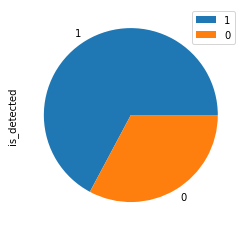

In [90]:
ratios.plot.pie()
plt.legend()

In [91]:
df.head(5)

,is_detected,roll,pitch,yaw,relative_time
0,0,NaN,NaN,NaN,0.000000
1,0,NaN,NaN,NaN,0.177751
2,0,NaN,NaN,NaN,0.323884
3,0,NaN,NaN,NaN,0.485754
4,1,0.617405,-2.64389,-1.459061,0.635699


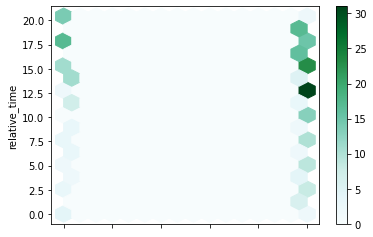

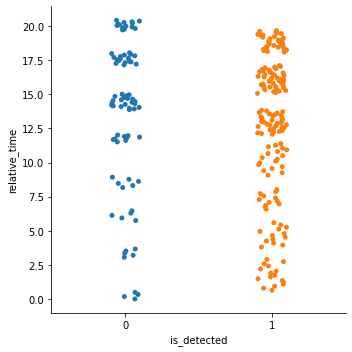

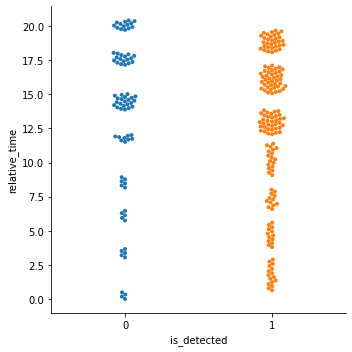

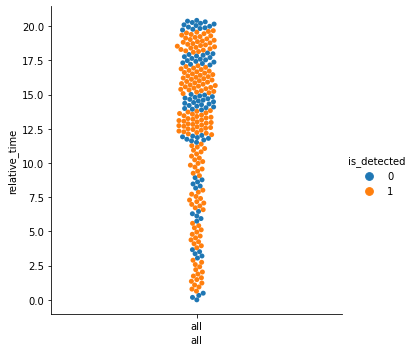

In [92]:
df.plot.hexbin(x=target, y="relative_time", gridsize=15)
sns.catplot(x=target, y='relative_time', data=df)
sns.catplot(x=target, y='relative_time', data=df, kind="swarm", s=4) # s=size of markers causes warnings when >4

# creating a dummy column for plotting both classes together
df.loc[:,'all'] = 'all'
sns.catplot(x='all', y='relative_time', data=df, hue=target, kind="swarm")